In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [3]:
import pandas as pd
import numpy as np
import pickle
from scipy.sparse import load_npz, hstack, vstack, csr_matrix, hstack
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split
from joblib import load
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras_tuner import HyperModel
from kerastuner.tuners import Hyperband
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.feature_selection import SelectKBest, f_classif

import matplotlib.pyplot as plt
import seaborn as sns


/var/folders/g5/qt49x61j0n737l58q9zvpq640000gn/T/ipykernel_5417/2729856809.py:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [4]:
X_train_sp = load_npz("X_train_sparse.npz")
X_test_sp = load_npz("X_test_sparse.npz")
X_train = X_train_sp.toarray()
X_test = X_test_sp.toarray()

y_test = np.load("y_test.npy")
y_train = np.load("y_train.npy")

full_df = pd.read_csv("full_df.csv")
texts = full_df["cleaned_body"]
labels = full_df["label"]

# Reconstruct text indices only (for model explainability)
all_indices = np.arange(len(labels))
X_train_idx, X_test_idx, _, _ = train_test_split(
    all_indices, labels, test_size=len(y_test), stratify=labels, random_state=42
)

train_texts = texts.iloc[X_train_idx].tolist()
test_texts = texts.iloc[X_test_idx].tolist()

In [4]:
# verify
print("🔹 BoW + TF-IDF Dense Feature Shapes:")
print(f"X_train: {X_train.shape} (type: {type(X_train)})")
print(f"X_test:  {X_test.shape} (type: {type(X_test)})")
print("-" * 40)

print("🔹 Label Shapes and Distribution:")
print(f"y_train: {y_train.shape}, classes: {np.unique(y_train, return_counts=True)}")
print(f"y_test:  {y_test.shape}, classes: {np.unique(y_test, return_counts=True)}")
print("-" * 40)

print(f"Train texts: {len(train_texts)} | Sample: {train_texts[0][:100]}")
print(f"Test texts:  {len(test_texts)}  | Sample: {test_texts[0][:100]}")
print("-" * 40)


🔹 BoW + TF-IDF Dense Feature Shapes:
X_train: (100806, 21500) (type: <class 'numpy.ndarray'>)
X_test:  (25202, 21500) (type: <class 'numpy.ndarray'>)
----------------------------------------
🔹 Label Shapes and Distribution:
y_train: (100806,), classes: (array([0, 1]), array([53102, 47704]))
y_test:  (25202,), classes: (array([0, 1]), array([13276, 11926]))
----------------------------------------
Train texts: 100745 | Sample: vince and ravi below is a message from the student whose resume i forwarded to you earlier this week
Test texts:  25202  | Sample: please distribute as wide as possible apologies for cross posting call for papers key terms in logic
----------------------------------------


# Feedforward Neural Network (FNN) on:
 1. BoW + TF-IDF
 2. word-grams + TF-IDF
 3. character-grams + TF-IDF

In [5]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=10, batch_size=64, callbacks=[early_stop]
)

/Users/sabav/vscode/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.9266 - loss: 0.2179 - val_accuracy: 0.9814 - val_loss: 0.0581
Epoch 2/10
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.9884 - loss: 0.0382 - val_accuracy: 0.9827 - val_loss: 0.0532
Epoch 3/10
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.9936 - loss: 0.0211 - val_accuracy: 0.9835 - val_loss: 0.0555
Epoch 4/10
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.9963 - loss: 0.0129 - val_accuracy: 0.9834 - val_loss: 0.0608
Epoch 5/10
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.9973 - loss: 0.0091 - val_accuracy: 0.9830 - val_loss: 0.0705


In [7]:


class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(
            units=hp.Int('units_input', min_value=64, max_value=512, step=64),
            activation='relu',
            input_shape=(X_train.shape[1],)))
        model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
        model.add(Dense(
            units=hp.Int('units_hidden', min_value=64, max_value=256, step=64),
            activation='relu'))
        model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(
            optimizer=Adam(hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

# STEP 2: Reload the saved tuner
tuner = Hyperband(
    MyHyperModel(),
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tuner_dir',
    project_name='fnn_spam_tuning'
)

# STEP 3: Retrieve the best model and parameters
best_model = tuner.get_best_models(num_models=1)[0]
best_params = tuner.get_best_hyperparameters(num_trials=1)[0]

# STEP 4: Print the best parameters
print("Best hyperparameters:")
for hp_name in best_params.values.keys():
    print(f"{hp_name}: {best_params.get(hp_name)}")

Reloading Tuner from tuner_dir/fnn_spam_tuning/tuner0.json
Best hyperparameters:
units_input: 384
dropout_1: 0.2
units_hidden: 256
dropout_2: 0.2
learning_rate: 0.0005524006632149828
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0010


/Users/sabav/vscode/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:
# Rebuild model using best params
model = Sequential([
    Dense(384, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005524006632149828),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

/Users/sabav/vscode/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.9586 - loss: 0.1202 - val_accuracy: 0.9830 - val_loss: 0.0502
Epoch 2/10
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.9928 - loss: 0.0227 - val_accuracy: 0.9845 - val_loss: 0.0551
Epoch 3/10
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.9974 - loss: 0.0089 - val_accuracy: 0.9856 - val_loss: 0.0752
Epoch 4/10
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.9990 - loss: 0.0038 - val_accuracy: 0.9852 - val_loss: 0.0888


788/788 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Accuracy: 0.983533052932307
Precision: 0.9771201193732902
Recall: 0.9883447928894852
F1 Score: 0.9827004043519947


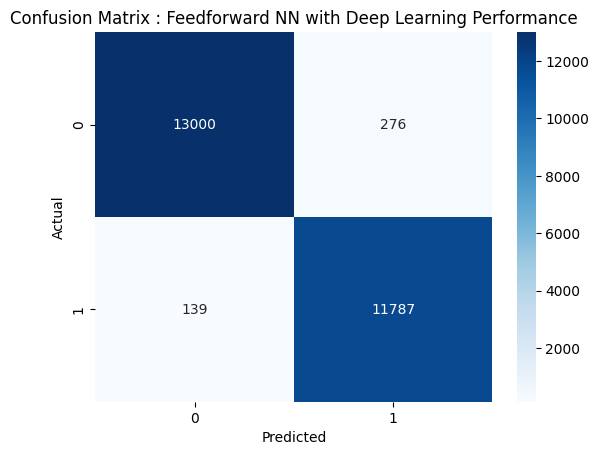

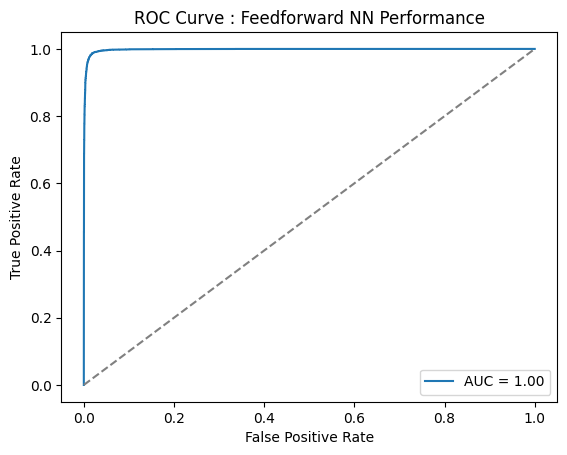

In [7]:
# Predict on test set
y_prob = model.predict(X_test)
y_pred = (y_prob > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix : Feedforward NN with Deep Learning Performance")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve : Feedforward NN Performance")
plt.legend()
plt.show()


In [6]:
with open('training_ngrams_tfidf.pkl', 'rb') as f:
    ngrams_tfidf = pickle.load(f)

print(ngrams_tfidf.info())


with open('engineered_features_bow_tfidf.pkl', 'rb') as f:
    bow_tfidf_dict = pickle.load(f)

bow_tfidf = pd.DataFrame(bow_tfidf_dict)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100784 entries, 0 to 100783
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   body             100784 non-null  object
 1   cleaned_body     100784 non-null  object
 2   label            100784 non-null  int64 
 3   tokens           100784 non-null  object
 4   body_tfidf       100784 non-null  object
 5   body_char_tfidf  100784 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.6+ MB
None


/Users/sabav/vscode/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/sabav/vscode/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/sabav/vscode/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.5.1 when using ve

In [19]:
feature_names_bow = bow_tfidf_dict["bow_vectorizer"].get_feature_names_out()
feature_names_tfidf = bow_tfidf_dict["tfidf_vectorizer"].get_feature_names_out()

feature_names = np.concatenate([
    feature_names_bow,
    feature_names_tfidf,
    [f"ngram_word_{i}" for i in range(1000)],
    [f"ngram_char_{i}" for i in range(500)]
])


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


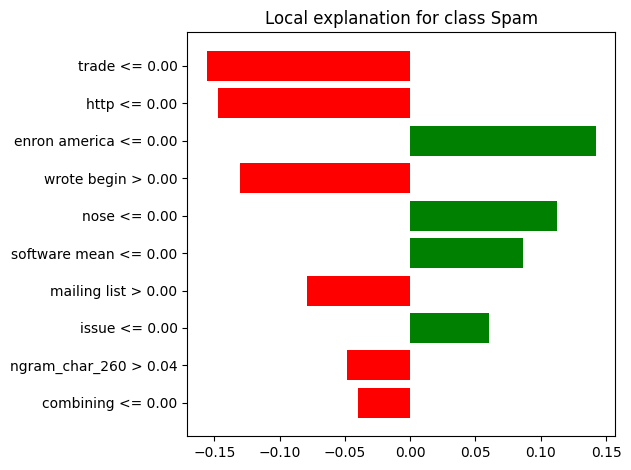

In [23]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import matplotlib.pyplot as plt

# Convert to float32 to save memory
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Sample training set for LIME only
lime_X_train = X_train[:3000]

explainer = LimeTabularExplainer(
    training_data=lime_X_train,
    feature_names=feature_names,
    class_names=["Ham", "Spam"],
    discretize_continuous=True,
    mode="classification"
)

def predict_fn(x):
    preds = model.predict(x)
    return np.hstack((1 - preds, preds))

# Then explain as before
exp = explainer.explain_instance(
    X_test[53],
    predict_fn,
    num_features=10,
    num_samples=1000
)

fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()